In [2]:


import os
import torch
print(torch.cuda.is_available())
print("Is CUDA available:", torch.cuda.is_available())
print("PyTorch CUDA version:", torch.version.cuda)
print("PyTorch version:", torch.__version__)

True
Is CUDA available: True
PyTorch CUDA version: 11.8
PyTorch version: 2.2.2+cu118


In [3]:
!pip install timm

In [4]:
import torch
#model = torch.load("../ckpts/convnext_base_ckpt5.pth")

In [5]:
import backbones_unet

print(backbones_unet.__available_models__)
from backbones_unet.model.unet import Unet
from backbones_unet.utils.dataset import SemanticSegmentationDataset
from backbones_unet.model.losses import DiceLoss
from backbones_unet.utils.trainer import Trainer
from torchsummary import summary
import torch
import torch.nn as nn
import timm
import torch
from torch.utils.data import DataLoader  # Import the DataLoader
from torchvision import transforms

['convnext_atto', 'convnext_atto_ols', 'convnext_base', 'convnext_base_384_in22ft1k', 'convnext_base_in22ft1k', 'convnext_base_in22k', 'convnext_femto', 'convnext_femto_ols', 'convnext_large', 'convnext_large_384_in22ft1k', 'convnext_large_in22ft1k', 'convnext_large_in22k', 'convnext_nano', 'convnext_nano_ols', 'convnext_pico', 'convnext_pico_ols', 'convnext_small', 'convnext_small_384_in22ft1k', 'convnext_small_in22ft1k', 'convnext_small_in22k', 'convnext_tiny', 'convnext_tiny_384_in22ft1k', 'convnext_tiny_hnf', 'convnext_tiny_in22ft1k', 'convnext_tiny_in22k', 'convnext_xlarge_384_in22ft1k', 'convnext_xlarge_in22ft1k', 'convnext_xlarge_in22k', 'cs3darknet_focus_l', 'cs3darknet_focus_m', 'cs3darknet_l', 'cs3darknet_m', 'cs3darknet_x', 'cs3edgenet_x', 'cs3se_edgenet_x', 'cs3sedarknet_l', 'cs3sedarknet_x', 'cspdarknet53', 'cspresnet50', 'cspresnext50', 'darknet53', 'darknetaa53', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'densenetblur121d', 'dm_nfnet_f0', 'dm_nfnet_f1',

In [6]:
print(os.getcwd())
backbone_name = "convnext_base"

c:\Users\charl\Research\442Proj\pretrained-backbones-unet


In [7]:
print(timm.list_models())

['bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_384', 'beit_large_patch16_512', 'beitv2_base_patch16_224', 'beitv2_large_patch16_224', 'botnet26t_256', 'botnet50ts_256', 'caformer_b36', 'caformer_m36', 'caformer_s18', 'caformer_s36', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_medium', 'coat_lite_medium_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_small', 'coat_tiny', 'coatnet_0_224', 'coatnet_0_rw_224', 'coatnet_1_224', 'coatnet_1_rw_224', 'coatnet_2_224', 'coatnet_2_rw_224', 'coatnet_3_224', 'coatnet_3_rw_224', 'coatnet_4_224', 'coatnet_5_224', 'coatnet_bn_0_rw_224', 'coatnet_nano_cc_224', 'coatnet_nano_rw_224', 'coatnet_pico_rw_224', 'coatnet_rmlp_0_rw_224', 'coatnet_rmlp_1_rw2_224', 'coatnet_rmlp_1_rw_224', 'coatnet_rmlp_2_rw_224', 'coatnet_rmlp_2

In [8]:
model = Unet(
    backbone=backbone_name, # backbone network name
    in_channels=3,            # input channels (1 for gray-scale images, 3 for RGB, etc.)
    num_classes=1,            # output channels (number of classes in your dataset)
)

In [9]:
print(sum(s.numel() for s in model.parameters()))

92651345


In [10]:
model2 = timm.create_model('convnext_base', pretrained=True)
print(model2.default_cfg)

{'url': 'https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_1k_224.pth', 'hf_hub_id': 'timm/convnext_base.fb_in22k_ft_in1k', 'architecture': 'convnext_base', 'tag': 'fb_in22k_ft_in1k', 'custom_load': False, 'input_size': (3, 224, 224), 'test_input_size': (3, 288, 288), 'fixed_input_size': False, 'interpolation': 'bicubic', 'crop_pct': 0.875, 'test_crop_pct': 1.0, 'crop_mode': 'center', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'num_classes': 1000, 'pool_size': (7, 7), 'first_conv': 'stem.0', 'classifier': 'head.fc'}


In [11]:
!nvidia-smi

Sat Apr 27 10:14:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.61                 Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   58C    P8              5W /   95W |     426MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [12]:

from backbones_unet.model.unet import Unet
from backbones_unet.utils.dataset import SemanticSegmentationDataset
from backbones_unet.model.losses import DiceLoss
from backbones_unet.utils.trainer import Trainer
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels       # Convert the image to a tensor  # and standard deviation
])
train_img_path = 'C:\\Users\\charl\\Research\\442Proj\\data\\1803241944\\clip_00000000'
train_mask_path = 'C:\\Users\\charl\\Research\\442Proj\\data\\1803241944\\matting_00000000'
print(os.listdir(train_mask_path))
val_img_path = '/content/drive/MyDrive/442_final_project/projectfile/clip_img/1803251920'
val_mask_path = '/content/drive/MyDrive/442_final_project/projectfile/clip_img/1803251920'
train_dataset = SemanticSegmentationDataset(train_img_path, train_mask_path,normalize=transform)
val_dataset = SemanticSegmentationDataset(val_img_path, val_mask_path,normalize=transform)
train_loader = DataLoader(train_dataset, batch_size=2)
val_loader = DataLoader(val_dataset, batch_size=2)
print(train_dataset.img_paths)
print(train_dataset.mask_paths)
print(val_dataset.img_paths)
print(val_dataset.mask_paths)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, 1e-4)

trainer = Trainer(
    model,                    # UNet model with pretrained backbone
    criterion=DiceLoss(),     # loss function for model convergence
    optimizer=optimizer,      # optimizer for regularization
    epochs=2                # number of epochs for model training
)


['1803241944-00000001.png', '1803241944-00000002.png', '1803241944-00000006.png', '1803241944-00000007.png', '1803241944-00000012.png', '1803241944-00000017.png', '1803241944-00000019.png', '1803241944-00000027.png', '1803241944-00000028.png', '1803241944-00000029.png', '1803241944-00000030.png', '1803241944-00000032.png', '1803241944-00000036.png', '1803241944-00000042.png', '1803241944-00000046.png', '1803241944-00000047.png', '1803241944-00000049.png', '1803241944-00000050.png', '1803241944-00000051.png', '1803241944-00000053.png', '1803241944-00000060.png', '1803241944-00000063.png', '1803241944-00000067.png', '1803241944-00000072.png', '1803241944-00000075.png', '1803241944-00000078.png', '1803241944-00000080.png', '1803241944-00000082.png', '1803241944-00000084.png', '1803241944-00000086.png', '1803241944-00000091.png', '1803241944-00000092.png', '1803241944-00000102.png', '1803241944-00000103.png', '1803241944-00000105.png', '1803241944-00000106.png', '1803241944-00000108.png', 

c:\Users\charl\Research\442Proj\pretrained-backbones-unet\backbones_unet\utils\trainer.py:128: UserWarning: Device was automatically selected: cuda
  warnings.warn(msg)


In [14]:
import os
def train_func(path):
    base_dir_img = "C:\\Users\\charl\\Research\\442Proj\\data\\clip_img"
    base_dir_mat = "C:\\Users\\charl\\Research\\442Proj\\data\\matting"
    parent_dir = os.listdir(base_dir_img)
    cnt = 1
    for parent in parent_dir:
        folder = os.path.join(base_dir_img,parent)
        folder_matting = os.path.join(base_dir_mat,parent)
        subfolder = os.listdir(folder)
        subfolder_mat = os.listdir(folder_matting)
        for i in range(len(subfolder)):
            sub = subfolder[i]
            sub_mat = subfolder_mat[i]
            sub_path = os.path.join(folder,sub)
            sub_path_matting = os.path.join(folder_matting,sub_mat)
            print(sub_path)
            img_folder = []
            mat_folder = []
            if os.path.isdir(sub_path) & os.path.isdir(sub_path_matting):
                img_folder = os.listdir(sub_path)
                mat_folder = os.listdir(sub_path_matting)
            print(len(img_folder))
            print(len(mat_folder))
            
            if(len(img_folder) > 0 and len(img_folder) == len(mat_folder)):
                #print("reached!")
                print(cnt)
                cnt += 1
                train_dataset = SemanticSegmentationDataset(sub_path, sub_path_matting,normalize=transform)
                val_img_path = 'C:\\Users\\charl\\Research\\442Proj\\data\\clip_img\\1803280525\\clip_00000000'
                val_mask_path = 'C:\\Users\\charl\\Research\\442Proj\\data\\matting\\1803280525\\matting_00000000'
                val_dataset = SemanticSegmentationDataset(val_img_path, val_mask_path,normalize=transform)
                #print(val_dataset.img_paths)
                train_loader = DataLoader(train_dataset, batch_size=8)
                val_loader = DataLoader(val_dataset, batch_size=8)
                trainer.fit(train_loader, val_loader)
                if cnt % 5 == 0:
                    print("saving")
                    torch.save(model, f"C:\\Users\\charl\\Research\\442Proj\\ckpts\\{backbone_name}_ckpt{cnt}.pth")
                if cnt == 10:
                    return
                

train_func("")

C:\Users\charl\Research\442Proj\data\clip_img\1803151818\clip_00000000
463
463
1
[]


Traning Model on 2 epochs:   0%|          | 0/2 [00:00<?, ?it/s]

: 

NameError: name 'np' is not defined

In [ ]:
print(train_dataset.img_paths)

['C:\\Users\\charl\\Research\\442Proj\\data\\1803241944\\clip_00000000\\1803241944-00000001.jpg', 'C:\\Users\\charl\\Research\\442Proj\\data\\1803241944\\clip_00000000\\1803241944-00000002.jpg', 'C:\\Users\\charl\\Research\\442Proj\\data\\1803241944\\clip_00000000\\1803241944-00000006.jpg', 'C:\\Users\\charl\\Research\\442Proj\\data\\1803241944\\clip_00000000\\1803241944-00000007.jpg', 'C:\\Users\\charl\\Research\\442Proj\\data\\1803241944\\clip_00000000\\1803241944-00000012.jpg', 'C:\\Users\\charl\\Research\\442Proj\\data\\1803241944\\clip_00000000\\1803241944-00000017.jpg', 'C:\\Users\\charl\\Research\\442Proj\\data\\1803241944\\clip_00000000\\1803241944-00000019.jpg', 'C:\\Users\\charl\\Research\\442Proj\\data\\1803241944\\clip_00000000\\1803241944-00000027.jpg', 'C:\\Users\\charl\\Research\\442Proj\\data\\1803241944\\clip_00000000\\1803241944-00000028.jpg', 'C:\\Users\\charl\\Research\\442Proj\\data\\1803241944\\clip_00000000\\1803241944-00000029.jpg', 'C:\\Users\\charl\\Research\\

In [ ]:
trainer.fit(train_loader, val_loader)

Traning Model on 10 epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 76/76 [00:11<00:00,  6.53 training-batch/s, loss=0.175]
0 validating-batch [00:00, ? validating-batch/s]
Epoch 2: 100%|██████████| 76/76 [00:10<00:00,  6.99 training-batch/s, loss=0.124]
0 validating-batch [00:00, ? validating-batch/s]
Epoch 3: 100%|██████████| 76/76 [00:10<00:00,  7.07 training-batch/s, loss=0.109]
0 validating-batch [00:00, ? validating-batch/s]
Epoch 4: 100%|██████████| 76/76 [00:10<00:00,  7.06 training-batch/s, loss=0.1]
0 validating-batch [00:00, ? validating-batch/s]
Epoch 5: 100%|██████████| 76/76 [00:10<00:00,  7.00 training-batch/s, loss=0.0927]
0 validating-batch [00:00, ? validating-batch/s]
Epoch 6: 100%|██████████| 76/76 [00:10<00:00,  7.03 training-batch/s, loss=0.0869]
0 validating-batch [00:00, ? validating-batch/s]
Epoch 7: 100%|██████████| 76/76 [00:10<00:00,  7.03 training-batch/s, loss=0.0805]
0 validating-batch [00:00, ? validating-batch/s]
Epoch 8: 100%|██████████| 76/76 [00:10<00:00,  7.04 training-batch/s, loss=0.0749]

torch.Size([2, 3, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 224, 224])
tensor([[[-5.7928, -7.7734, -8.3327,  ..., -8.3700, -7.2418, -6.3193],
         [-7.7684, -8.9185, -8.7442,  ..., -8.8811, -8.7917, -7.7467],
         [-8.2652, -8.1032, -7.9056,  ..., -8.1811, -8.7306, -8.1286],
         ...,
         [ 6.3924,  5.3210,  5.5995,  ...,  5.7335,  6.3311,  5.4840],
         [ 6.4280,  5.8535,  5.7826,  ...,  5.8068,  5.7868,  5.2666],
         [ 4.0782,  5.3420,  5.4224,  ...,  4.6095,  3.7868,  3.9012]],

        [[-5.4699, -7.5846, -8.3010,  ..., -8.3853, -7.1923, -6.2397],
         [-7.5497, -8.7585, -8.6359,  ..., -8.9589, -8.6182, -7.5326],
         [-8.0698, -8.0670, -7.6110,  ..., -8.1940, -8.5034, -7.8448],
         ...,
         [ 6.4835,  5.4055,  5.6977,  ...,  1.3647, -0.5061, -0.3818],
         [ 6.5207,  5.8399,  5.7584,  ...,  1.0436, -0.9729, -1.3059],
         [ 4.2340,  5.3316,  5.4070,  ...,  1.2435, -0.4142, -0.7558]]],
       device='cuda:0')


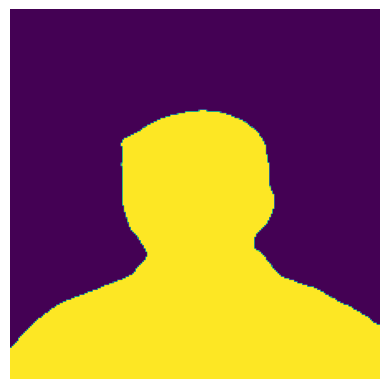

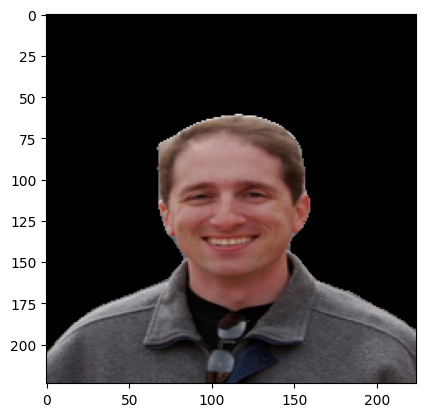

torch.Size([2, 3, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 224, 224])
tensor([[[-5.6474, -7.8161, -8.4581,  ..., -8.4102, -7.2930, -6.2872],
         [-7.6401, -8.9136, -8.7252,  ..., -8.9345, -8.7910, -7.7045],
         [-8.1261, -8.1201, -7.7537,  ..., -8.1566, -8.7111, -8.0743],
         ...,
         [-7.7934, -8.0871, -8.0491,  ...,  5.8762,  6.2833,  5.3423],
         [-7.5483, -7.9987, -7.8958,  ...,  5.8711,  5.6942,  4.9702],
         [-7.4743, -8.6861, -8.8486,  ...,  4.5340,  3.7179,  3.7015]],

        [[-5.4078, -7.5900, -8.2862,  ..., -8.2455, -7.0780, -6.0553],
         [-7.5232, -8.8205, -8.7261,  ..., -8.9449, -8.4116, -7.2359],
         [-8.0573, -8.0311, -7.6947,  ..., -8.3172, -8.3819, -7.5717],
         ...,
         [ 6.3864,  5.3562,  5.6619,  ...,  5.9019,  6.2321,  5.2390],
         [ 6.4730,  5.8096,  5.8573,  ...,  5.7961,  5.6039,  4.8651],
         [ 4.1953,  5.3559,  5.4509,  ...,  4.5586,  3.6751,  3.5121]]],
       device='cuda:0')


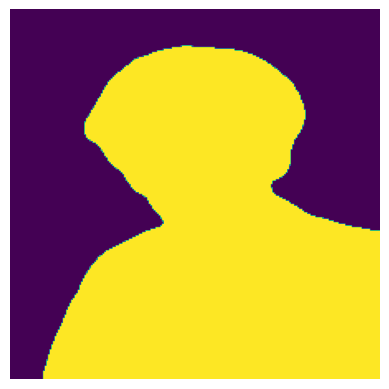

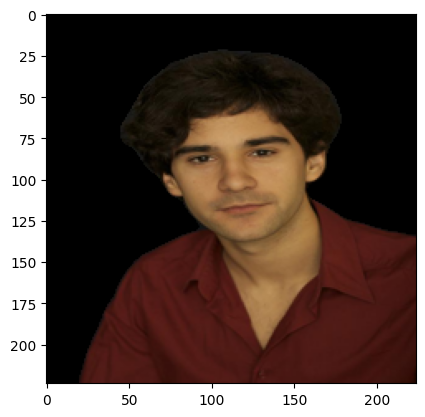

torch.Size([2, 3, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 224, 224])
tensor([[[-5.5577, -7.7486, -8.4474,  ..., -8.4244, -7.2938, -6.2796],
         [-7.6096, -8.8115, -8.6642,  ..., -8.9858, -8.8029, -7.6840],
         [-8.0940, -8.0800, -7.6460,  ..., -8.1292, -8.6740, -8.0064],
         ...,
         [ 6.5749,  5.4392,  5.8048,  ...,  5.5513,  5.0306,  3.0230],
         [ 6.6407,  5.7497,  5.8992,  ...,  5.4123,  4.3059,  2.1779],
         [ 4.3515,  5.4233,  5.5244,  ...,  4.1452,  3.1213,  1.8016]],

        [[-5.6503, -7.8077, -8.4300,  ..., -8.4390, -7.3088, -6.2705],
         [-7.6417, -8.9211, -8.7476,  ..., -8.9459, -8.7588, -7.6485],
         [-8.1102, -8.0942, -7.7419,  ..., -8.1704, -8.6969, -8.0244],
         ...,
         [ 6.4599,  5.4182,  5.7700,  ...,  5.8559,  6.3317,  5.4128],
         [ 6.6004,  5.8093,  5.9486,  ...,  5.8618,  5.7034,  5.2087],
         [ 4.3091,  5.4162,  5.5095,  ...,  4.6602,  3.7497,  3.8603]]],
       device='cuda:0')


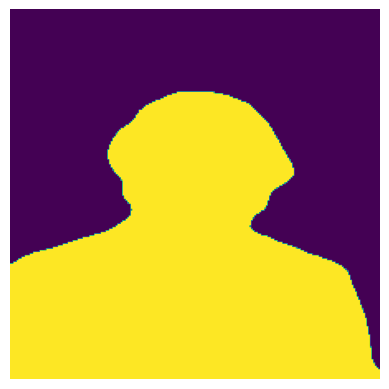

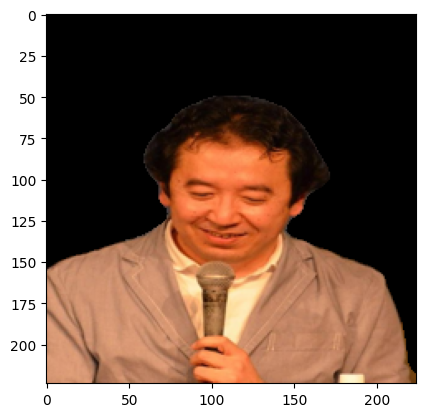

torch.Size([2, 3, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 224, 224])
tensor([[[-5.5860, -7.7885, -8.4175,  ..., -8.4036, -7.2970, -6.3164],
         [-7.6473, -8.9435, -8.7382,  ..., -8.8843, -8.8168, -7.7065],
         [-8.1672, -8.2246, -7.8146,  ..., -8.2142, -8.7921, -8.1142],
         ...,
         [ 6.4082,  5.5313,  5.8838,  ...,  5.1085,  4.3637,  2.5418],
         [ 6.3815,  5.7506,  5.9349,  ...,  4.7621,  3.5713,  1.4514],
         [ 4.1863,  5.2126,  5.2776,  ...,  3.3405,  2.1637,  1.1246]],

        [[-5.5130, -7.6851, -8.3917,  ..., -8.3844, -7.2169, -6.3030],
         [-7.5422, -8.7585, -8.6185,  ..., -8.8965, -8.7293, -7.6875],
         [-8.0729, -8.0814, -7.6497,  ..., -8.2532, -8.7116, -8.0876],
         ...,
         [ 6.1558,  5.4966,  5.6507,  ...,  6.0086,  6.3200,  5.3375],
         [ 6.2598,  5.8604,  5.7201,  ...,  5.8358,  5.7328,  5.0738],
         [ 3.9512,  5.2404,  5.2865,  ...,  4.5143,  3.7546,  3.7575]]],
       device='cuda:0')


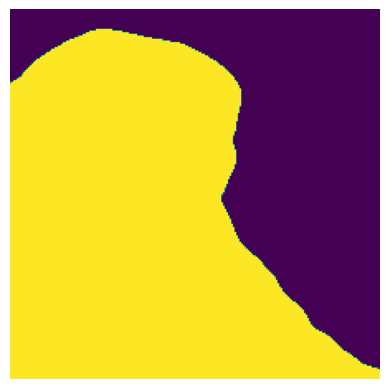

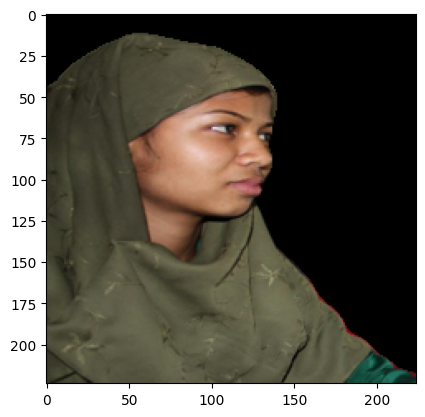

torch.Size([2, 3, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 224, 224])
tensor([[[-5.5755, -7.7248, -8.3994,  ..., -8.3487, -7.2048, -6.3111],
         [-7.5770, -8.7657, -8.5908,  ..., -8.8450, -8.7294, -7.7193],
         [-8.1013, -8.0654, -7.6436,  ..., -8.2082, -8.7022, -8.1137],
         ...,
         [ 5.5613,  5.0193,  5.4264,  ...,  5.8507,  6.1715,  5.1697],
         [ 5.4845,  5.3546,  5.3975,  ...,  5.8456,  5.6028,  4.8254],
         [ 3.2745,  4.5946,  4.8350,  ...,  4.3127,  3.5579,  3.4690]],

        [[-5.5915, -7.7617, -8.4002,  ..., -8.4368, -7.2742, -6.2702],
         [-7.6133, -8.8695, -8.7175,  ..., -8.9419, -8.7413, -7.6650],
         [-8.1052, -8.1169, -7.7540,  ..., -8.2053, -8.7028, -8.0500],
         ...,
         [ 6.3044,  5.4665,  5.7355,  ...,  5.9084,  6.2916,  5.3064],
         [ 6.3861,  5.9285,  5.7631,  ...,  5.8552,  5.6815,  4.9425],
         [ 4.0805,  5.3069,  5.4044,  ...,  4.5408,  3.6998,  3.6834]]],
       device='cuda:0')


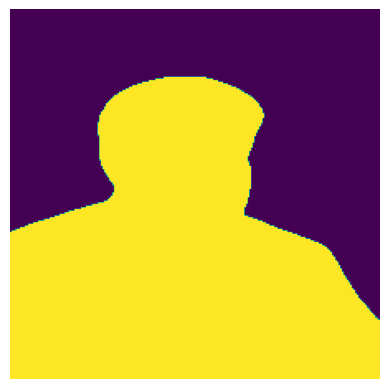

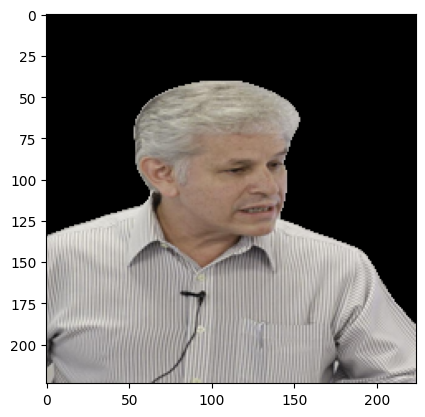

In [28]:
import matplotlib.pyplot as plt
import numpy as np
for i, (inputs, labels) in enumerate(train_loader):
        # Your training process, e.g., forward pass, backward pass, optimize, etc.
        print(inputs.shape)
        print(labels.shape)
        #print(labels[0,0])
        #print(inputs)
        outputs = model.predict(inputs.to('cuda')).squeeze()
# Ensure it's suitable for display: clip values to be within the interval [0, 1]
        print(outputs.shape)
# Display the image
        print(outputs)
        outputs = torch.clamp(outputs, min=0, max=1)
        plt.imshow(outputs[0].cpu())
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.show()
        out = inputs[0] * outputs[0].cpu()
        plt.imshow(out.squeeze().permute(1,2,0))
        plt.show()
        plt.imshow(labels[0])
        plt.show()
        if i == 4:
          break

In [44]:
import os
import cv2
# Open the video file
cap = cv2.VideoCapture('./multiple.mp4')
frames = []
try:
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
        if not ret:
            break  # Break the loop if there are no frames left
        
        # Optionally resize or preprocess the frame here if necessary
        frames.append(frame)
finally:
    cap.release()  # Make sure to release the video capture object
  
print(frames)

[array([[[165, 187, 197],
        [165, 187, 197],
        [164, 186, 196],
        ...,
        [134, 146, 172],
        [134, 146, 172],
        [134, 146, 172]],

       [[165, 187, 197],
        [165, 187, 197],
        [164, 186, 196],
        ...,
        [134, 146, 172],
        [134, 146, 172],
        [134, 146, 172]],

       [[165, 187, 197],
        [165, 187, 197],
        [164, 186, 196],
        ...,
        [134, 146, 172],
        [134, 146, 172],
        [134, 146, 172]],

       ...,

       [[101,  80,  66],
        [101,  80,  66],
        [101,  80,  66],
        ...,
        [133, 100,  88],
        [133, 100,  88],
        [133, 100,  88]],

       [[112,  91,  77],
        [112,  91,  77],
        [112,  91,  77],
        ...,
        [134, 101,  89],
        [134, 101,  89],
        [134, 101,  89]],

       [[102,  81,  67],
        [102,  81,  67],
        [102,  81,  67],
        ...,
        [137, 104,  92],
        [137, 104,  92],
        [137, 104,  92]

In [45]:
from PIL import Image
def preprocess(img):
    img = img.resize((224, 224)) 
    img = torch.Tensor(np.array(img, dtype=np.uint8).transpose((2, 0, 1)))
    img = img.float() / 255.0
    return img

segmented_frames = []
cnt = 0
for frame in frames:
    # Convert frame to RGB (OpenCV uses BGR format by default)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    input_tensor = preprocess(Image.fromarray(rgb_frame))
    print(input_tensor.shape)
    input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model
    cnt += 1
    #plt.imshow(input_batch[0].permute(1,2,0))
    #plt.show()
    # Move the input and model to GPU for faster computation
    input_batch = input_batch.to('cuda')
    model.to('cuda')
    with torch.no_grad():
        output = model(input_batch)
        print(output.shape)
    out = input_tensor * output[0].cpu().clamp(0,1)
    #plt.imshow(out.permute(1,2,0))
    #plt.show()
    # Assuming output is a segmented tensor, converting it to an image:
    # This step depends heavily on what your model outputs
    output_image = out.cpu().data.squeeze().numpy()  # Example conversion, adjust as necessary
    segmented_frames.append(output_image)

torch.Size([3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size

In [46]:
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MP4V')  # or (*'XVID') depending on the desired output format
out = cv2.VideoWriter('multiple_output.mp4', fourcc, 40.0, (224,224))

for frame in segmented_frames:
    frame = frame.transpose((1, 2, 0))
    if frame.dtype != np.uint8:
        frame = (frame * 255).astype(np.uint8)
    #plt.imshow(frame)
    #plt.show()
    print(frame.shape)
    # Convert your processed frame back to BGR from RGB if necessary
    bgr_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    out.write(bgr_frame)

out.release()  # Release everything if job is finished

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 

In [69]:

def preprocess(img):
    img = img.resize((224, 224)) 
    img = torch.Tensor(np.array(img, dtype=np.uint8).transpose((2, 0, 1)))
    img = img.float() / 255.0
    return img
def getVideo(in_path,out_path):
    cap = cv2.VideoCapture(in_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frames = []
    try:
        while True:
            # Read a frame from the video
            ret, frame = cap.read()
            if not ret:
                break  # Break the loop if there are no frames left
            
            # Optionally resize or preprocess the frame here if necessary
            frames.append(frame)
    finally:
        cap.release()  # Make sure to release the video capture objec
    print(frames[0].shape)
    H, W, C = frames[0].shape
    segmented_frames = []
    cnt = 0
    #print(len(frames))
    for frame in frames:
        # Convert frame to RGB (OpenCV uses BGR format by default)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        input_tensor = preprocess(Image.fromarray(rgb_frame))
        #print(input_tensor.shape)
        input_batch = input_tensor.unsqueeze(0)
        cnt += 1
        #plt.imshow(input_batch[0].permute(1,2,0))
        #plt.show()
        input_batch = input_batch.to('cuda')
        model.to('cuda')
        with torch.no_grad():
            output = model(input_batch)
            #print(output.shape)
        out = input_tensor * output[0].cpu().clamp(0,1)
        #plt.imshow(out.permute(1,2,0))
        #plt.show()
        output_image = out.cpu().data.squeeze().numpy()  # Example conversion, adjust as necessary
        segmented_frames.append(output_image)
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')  # or (*'XVID') depending on the desired output format
    out = cv2.VideoWriter(out_path, fourcc, 20.0, (224,224))
    for frame in segmented_frames:
        frame = frame.transpose((1, 2, 0))
        if frame.dtype != np.uint8:
            frame = (frame * 255).astype(np.uint8)
        #plt.imshow(frame)
        #plt.show()
        #print(frame.shape)
        bgr_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(bgr_frame)
    out.release() 
    
getVideo("./test.mp4","./testout.mp4")

(1280, 720, 3)
